# PY Net éléc

Analyse des données de consommation et de production via l'application eco2mix

## Sommaire

* [Partie 1 - Pré-analyse](#partie1)
    * [Section 1.1 - Import des données](#section_1_1)
        * [Section 1.1.1 - Conversion des dates](#section_1_1_1)
        * [Section 1.1.2 - Renommage](#section_1_1_2)
        * [Section 1.1.3 - Ajout de variables](#section_1_1_3)
    * [Section 1.3 - Filtrage](#section_1_3)
    * [Section 1.4 - Séparation des données de conso. de production](#section_1_4)
    * [Section 1.5 - Analyse des données de consommation](#section_1_5)
        * [Section 1.5.1 - Préparation analyse mensuel](#section_1_5_1)
        * [Section 1.5.2 - Synthèse analyse mensuel](#section_1_5_2)
        * [Section 1.5.3 - Analyse hebdomadaire](#section_1_5_3)
        * [Section 1.5.3 - Préparation analyse par tranche horaire](#section_1_5_4)
    * [Section 1.6 - Analyse des données de production vs consommation](#section_1_6)
        * [Section 1.6.1 - Préparation analyse mensuel](#section_1_6_1)
        * [Section 1.6.2 - Synthèse analyse production mensuel](#section_1_6_2)
        * [Section 1.6.3 - préparation analyse prod. vs conso. mensuel](#section_1_6_3)
        * [Section 1.6.4 - Synthèse analyse prod. vs conso. mensuel](#section_1_6_4)
    * [Section 1.7 - Production par filière](#section_1_7)
        * [Section 1.7.1 - préparation analyse production mensuel par filière](#section_1_7_1)
        * [Section 1.7.2 - synthèse analyse production mensuel par filière](#section_1_7_2)
        * [Section 1.7.3 - préparation analyse production hebdomadaire par filière](#section_1_7_3)
        * [Section 1.7.4 - synthèse analyse production hebdomadaire par filière](#section_1_7_4)
    * [Section 1.8 - Hypothèse à vérifier](#section_1_8)

# Partie 1 - Pré-analyse <a class="anchor" id="Partie1"></a>

## Section 1.1 - Import des données <a class="anchor" id="section_1_1"></a>

In [1]:
#Import des packages
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
sns.set_theme()
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [64]:
#Création de différentes fonction
def agregat(variables: list, fonctions: list) -> tuple:
    '''
    Return a dictionary wich variables is associated with one or many functions.

            >Parameters:
                    - variables (list): Name of variables which function is applied
                    - fonctions (list): function to apply

            >Returns:
                    - agregat(tuple): dictionary containing combinations of variables and functions
    '''
    
    agregat = {}

    for variable in variables:
        agregat[variable] = fonctions

    return agregat


def groupage(data, var_group, agregat: tuple):
    '''
    Return a dataframe which is grouped and functions are applied on variables.

            >Parameters:
                    - data : Dataframe should be grouped
                    - var_group : variable on which dataframe it should be grouped
                    - agregat : variables with functions should be applied

            >Returns:
                    - group: dataframe combine with functions are applied on variables
    '''

    group = data.groupby(by = var_group).agg(agregat)
    group.columns = ['_'.join(col) for col in group.columns]

    return group


def dataVariables(data_cols, funs=['_min','_max','_mean','_std', '_median','_firstQuart', '_thirdQuart']):
    '''
    Return list of variables contains in dataframe

            >Parameters:
                    - data_cols : columns of dataframe
                    - funs : list of function that have been applied

            >Returns:
                    - variables: list of variables without function
    '''
    variables = []
    for col in data_cols:
        for fun in funs:
            if fun in col:
                variables.append(col.replace(fun,''))
    variables = list(dict.fromkeys(variables))
    return variables


def firstQuart(x):
    '''
    Return the first quartile of elements.
            >Parameters:
                    - X: input array
    
    '''
    return x.quantile(0.25)


def thirdQuart(x):
    '''
    Return the third quartile of elements.
            Parameters:
                    - X: input array
    
    '''
    return x.quantile(0.75)


def loopPlot(data, x_label=None, title=None):

    #Récupère le nom des différentes variables et calcul leurs nombres
    variables = dataVariables(data_cols=data.columns)
    n_variables = len(variables)
    x = range(len(data))

    #Création de dico pour les figures
    fig = {}
    axs = {}
    
    #Création de la figure
    fig = plt.figure(figsize=(15,15), constrained_layout=True)
        
    fig.suptitle(title, size=18)

    for idx, var in enumerate(variables):
        #Création des sous-graphiques en fonction des différentes variables
        axs[idx] = fig.add_subplot(n_variables,1,idx + 1)


        #Tracé de la limite inférieur
        if var + '_min' in data.columns:
            line_min, = axs[idx].plot(x, data[var + '_min'])
            line_min.set_color('#929591')
            line_min.set_alpha(0.5)
            line_min.set_linestyle(':')
            

        #Tracé de la limité supérieur
        if var + '_max' in data.columns:
            line_max, = axs[idx].plot(x, data[var + '_max'])
            line_max.set_color('#929591')
            line_max.set_alpha(0.5)
            line_max.set_linestyle(':')


        #Tracé du 1er quartile
        if var + '_firstQuart' in data.columns:
            line_min, = axs[idx].plot(x, data[var + '_firstQuart'])
            line_min.set_color('#929591')
            line_min.set_alpha(0.7)
            line_min.set_linestyle('--')


        #Tracé du 3ème
        if var + '_thirdQuart' in data.columns:
            line_max, = axs[idx].plot(x, data[var + '_thirdQuart'])
            line_max.set_color('#929591')
            line_max.set_alpha(0.7)
            line_max.set_linestyle('--')


        #Tracé de la moyenne
        line_mean, = axs[idx].plot(x, data[var + '_mean'])
        line_mean.set_color(colours[var])
        line_mean.set_label(f"production {var} moyenne")


        #Tracé de la bande mini-maxi
        if (var + '_min' in data.columns) and (var + '_max' in data.columns):
            axs[idx].fill_between(x, data[var + '_min'], data[var + '_max'], color='#929591', alpha=0.3)


        #Tracé de la bande Q25-Q75
        if (var + '_firstQuart' in data.columns) and (var + '_thirdQuart' in data.columns):
            axs[idx].fill_between(x, data[var + '_firstQuart'], data[var + '_thirdQuart'], color='#929591', alpha=0.7)


        #Renommage de l'axe des abscisses
        if x_label:
            axs[idx].set_xticks(range(len(data)))
            axs[idx].set_xticklabels(x_label)
        

        #Renommage de l'axe des ordonnées
        axs[idx].set_ylabel('MW')
        

        #Correction des limites du graphiques
        axs[idx].set_xlim(0,len(data)-1)


        #Ajout de la légende
        plt.legend(loc='upper right')

    return fig, axs


In [2]:
#import des données
df = pd.read_csv("eco2mix-regional-cons-def.csv", sep=";")

In [3]:
#Liste des différentes variables et leur types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875456 entries, 0 to 1875455
Data columns (total 28 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Code INSEE région    int64  
 1   Région               object 
 2   Nature               object 
 3   Date                 object 
 4   Heure                object 
 5   Date - Heure         object 
 6   Consommation (MW)    float64
 7   Thermique (MW)       float64
 8   Nucléaire (MW)       float64
 9   Eolien (MW)          float64
 10  Solaire (MW)         float64
 11  Hydraulique (MW)     float64
 12  Pompage (MW)         float64
 13  Bioénergies (MW)     float64
 14  Ech. physiques (MW)  float64
 15  TCO Thermique (%)    float64
 16  TCH Thermique (%)    float64
 17  TCO Nucléaire (%)    float64
 18  TCH Nucléaire (%)    float64
 19  TCO Eolien (%)       float64
 20  TCH Eolien (%)       float64
 21  TCO Solaire (%)      float64
 22  TCH Solaire (%)      float64
 23  TCO Hydraulique (%)  float64
 24

#### Section 1.1.1 - Conversion des dates<a class="anchor" id="section_1_1_1"></a>

In [3]:
#Conversion des variables Date et Heure en objet date
df['Date - Heure'] = df['Date'] +'T'+ df['Heure'] 
df['Date - Heure'] = pd.to_datetime(df['Date - Heure'], format="%Y-%m-%dT%H:%M")

#Suppression des colonnes date et heure
df = df.drop(['Date','Heure'], axis=1)

#### Section 1.1.2 - Renommage<a class="anchor" id="section_1_1_2"></a>
Renommage des différentes colonnes

In [4]:
#Renommage de la colonne date
df = df.rename(columns={'Date - Heure':'Date'})

In [5]:
#supppresion de (MW) et (%) dans les noms de colonnes
df.columns = df.columns.str.replace("(MW)","")
df.columns = df.columns.str.replace("(%)","")

df.columns = df.columns.str.replace("(","")
df.columns = df.columns.str.replace(")","")

df.columns = df.columns.str.rstrip()

#Remplacement des espaces par _ dans les noms de colonnes
df.columns = df.columns.str.replace(" ","_")

C:\Users\menag\AppData\Local\Temp/ipykernel_43516/2013184060.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("(MW)","")
C:\Users\menag\AppData\Local\Temp/ipykernel_43516/2013184060.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("(%)","")
C:\Users\menag\AppData\Local\Temp/ipykernel_43516/2013184060.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace("(","")
C:\Users\menag\AppData\Local\Temp/ipykernel_43516/2013184060.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=Tru

#### Section 1.1.3 - Ajout de variables<a class="anchor" id="section_1_1_3"></a>

In [6]:
#Suppresion de la colonne 26
df = df.iloc[:,:-1]

#Ajout d'une variable production qui correspond au total de production
df['Production'] = df['Thermique'] + df['Nucléaire'] + df['Eolien'] + df['Solaire'] + df['Hydraulique'] + df['Bioénergies']

#Calcul de la part de production de chaque filière dans le mix énergétique
df['P_thermique'] = (df['Thermique'] / df['Production'])*100
df['P_nucléaire'] = (df['Nucléaire'] / df['Production'])*100
df['P_eolien'] = (df['Eolien'] / df['Production'])*100
df['P_solaire'] = (df['Solaire'] / df['Production'])*100
df['P_hydraulique'] = (df['Hydraulique'] / df['Production'])*100
df['P_bio'] = (df['Bioénergies'] / df['Production'])*100

#Couleur en fonction des filières
colours = {
    'Thermique':'C0',
    'Nucléaire':'C1',
    'Solaire':'C2',
    'Hydraulique':'C3',
    'Bioénergies':'C4',
    'Eolien':'C5'
}


In [8]:
#liste des différents variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875456 entries, 0 to 1875455
Data columns (total 32 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Code_INSEE_région  int64         
 1   Région             object        
 2   Nature             object        
 3   Date               datetime64[ns]
 4   Consommation       float64       
 5   Thermique          float64       
 6   Nucléaire          float64       
 7   Eolien             float64       
 8   Solaire            float64       
 9   Hydraulique        float64       
 10  Pompage            float64       
 11  Bioénergies        float64       
 12  Ech._physiques     float64       
 13  TCO_Thermique      float64       
 14  TCH_Thermique      float64       
 15  TCO_Nucléaire      float64       
 16  TCH_Nucléaire      float64       
 17  TCO_Eolien         float64       
 18  TCH_Eolien         float64       
 19  TCO_Solaire        float64       
 20  TCH_Solaire        float

## Section 1.3 - Filtrage<a class="anchor" id="section_1_3"></a>

Sélection d'une région sur une année en vue d'une pré-analyse

In [7]:
#Sélection des données définitives pour la région centre val de loire sur l'année 2020
sample = df.loc[(df.Nature=='Données définitives')&(df.Région=='Centre-Val de Loire')&(df['Date'].dt.year==2020),:]

In [10]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17568 entries, 1472266 to 1683069
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Code_INSEE_région  17568 non-null  int64         
 1   Région             17568 non-null  object        
 2   Nature             17568 non-null  object        
 3   Date               17568 non-null  datetime64[ns]
 4   Consommation       17568 non-null  float64       
 5   Thermique          17568 non-null  float64       
 6   Nucléaire          17568 non-null  float64       
 7   Eolien             17568 non-null  float64       
 8   Solaire            17568 non-null  float64       
 9   Hydraulique        17568 non-null  float64       
 10  Pompage            0 non-null      float64       
 11  Bioénergies        17568 non-null  float64       
 12  Ech._physiques     17568 non-null  float64       
 13  TCO_Thermique      17568 non-null  float64       
 14

## Section 1.4 Séparation des données de conso. de production <a class="anchor" id="section_1_4"></a>

In [8]:
#Séparation des données de consommation de production
prod = sample.iloc[:, [3,5,6,7,8,9,11,14,16,18,20,22,24,25,26,27,28,29,30,31]]
conso = sample.iloc[:, [3,4]]



Les données de la production par pompage ne sont pas prises en considération, car elles sont nulles sur la région centre.
Dans le but de simplifier les analyses, les données liées aux échanges énergétique sont exclues.

## Section 1.5 - Analyse des données de consommation<a class="anchor" id="section_1_5"></a>

### Section 1.5.1 - Préparation analyse mensuel<a class="anchor" id="section_1_5_1"></a>

In [12]:
#Définition des mois
month = {
    0:'Janv.',
    1:'Fev.',
    2:'Mars',
    3:'Avr.',
    4:'Mai',
    5:'Juin',
    6:'Juil.',
    7:'Aout',
    8:'Sept.',
    9:'Oct.',
    10:'Nov.',
    11:'Dec.'
}

#Calcul des données total consommées
conso_mensuel = conso.groupby(by=conso.Date.dt.month, as_index=False).agg({'Consommation':'sum'}).round(1)

#Remplace de l'index par le mois
conso_mensuel = conso_mensuel.reset_index().rename(columns={'index':'Mois'}).replace(month).set_index('Mois')

#Conversion des données de conso en GW
conso_mensuel = conso_mensuel/1000

#Calcul conso haute et basse saison
haute_saison = conso_mensuel.sort_values(by='Consommation').head(6).mean().round(2)['Consommation']
basse_saison = conso_mensuel.sort_values(by='Consommation').tail(6).mean().round(2)['Consommation']

### Section 1.5.2 - Synthèse analyse mensuel<a class="anchor" id="section_1_5_2"></a>

Nous estimerons que l'année peut-être découper en 2 saisons distinctes. 
 - La première sera la haute saison où l'hivers. Durant cette saison la consommation sera maximale.
 - La deuxième sera la basse saison où l'été. Durant cette saison la consommation sera minimale.


In [13]:
print("La conso moyenne durant la haute saison est en GW de: ",basse_saison)

La conso moyenne durant la haute saison est en GW de:  3603.43


In [ ]:
print("La conso moyenne durant la basse saison est en GW de :",haute_saison)

In [ ]:
print("La différence entre la basse et la haute saison est de %:\n",
(haute_saison/basse_saison)*100
)

In [ ]:
#Création de la figure
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

#Tracé de la courbe de la conso. mensuel
ax1.plot(conso_mensuel, label='conso. total')

#ajout de la conso. moyenne basse saison
ax1.plot([i for i in range(3,9)],[conso_mensuel.sort_values(by='Consommation').head(6).mean()['Consommation'] for i in range(6)], linestyle='--', color='green', label=f"conso. moyenne basse saison {basse_saison}")
#ajout de la conso. moyenne haute saison
ax1.plot([i for i in range(3)],[conso_mensuel.sort_values(by='Consommation').tail(6).mean()['Consommation'] for i in range(3)], linestyle='--', color='red', label=f"conso. moyenne haute saison {haute_saison}")
ax1.plot([i for i in range(9,12)],[conso_mensuel.sort_values(by='Consommation').tail(6).mean()['Consommation'] for i in range(3)], linestyle='--', color='red')

#ajout de la fleche
ax1.annotate('Haute VS Basse saison', xy=(9,basse_saison), xytext=(9,haute_saison), arrowprops={'facecolor':'black'});

#Titre des axes
ax1.set_ylabel('GW')
ax1.set_xlabel('2020')

#Ajout des limites sur l'axe des abscisses
ax1.set_xlim(0,11)

#ajout de la légende
ax1.legend(loc='upper center')

#Titre du graphique
ax1.set_title('Evolution de la consommation mensuel pour la région centre',fontsize=14);

### Section 1.5.3 - Analyse hebdomadaire<a class="anchor" id="section_1_5_3"></a>

In [ ]:
#Caclul des données consommées par jour
conso_hebdo = conso.groupby(by=conso.Date.dt.isocalendar().day).agg({'Consommation':'sum'}).round(1).reset_index()

#Renommage des colonnes
conso_hebdo = conso_hebdo.rename(columns={'day':'Jour'})

#Remplacement des numéro par les jours
conso_hebdo['Jour'] = conso_hebdo.Jour.replace([i for i in range(1,8)],['Lundi','Mardi','Mercredi','Jeudi','Vendredi','Samedi','Dimanche'])

#Conversion en GW
conso_hebdo['Consommation'] = conso_hebdo.Consommation/1000

#retour des conso. hebdomadaire
print(conso_hebdo)

#Différence entre le week-end et la semaine
print("la consommation en semaine est de : ",conso_hebdo.iloc[:5,1].mean())
print("la consommation le week-end est de : ",conso_hebdo.iloc[-2:,1].mean())
print("La différence entre la semaine et le week-end est de %: ",(1-((conso_hebdo.iloc[-2:,1].mean())/(conso_hebdo.iloc[:5,1].mean())))*100)


In [ ]:
plt.figure(figsize=(8,6))
sns.lineplot(x=conso_hebdo.Jour, y=conso_hebdo.Consommation)
plt.title('Consommation total hebdomadaire');

Il n'y a pas de différence significative entre le week-end et la semaine sur la consommation.

### Section 1.5.4 - Préparation analyse par tranche horaire<a class="anchor" id="section_1_5_4"></a>

In [ ]:
#Calcul des données total consommées
conso_heure = conso.groupby(by=conso.Date.dt.hour, as_index=False).agg({'Consommation':'sum'}).round(1)

#Conversion des données de conso en GW
conso_heure = conso_heure/1000

In [ ]:
#Création de la figure
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

#Tracé de la courbe de la conso. mensuel
ax1.plot(conso_heure, label='conso. total')

#Titre des axes
ax1.set_ylabel('GW')

#Modification des graduations des abscisses
ax1.set_xticks(range(0,24,1))

#Ajout des limites sur l'axe des abscisses
ax1.set_xlim(0,23,2)

#ajout de la légende
ax1.legend(loc='lower right')

#Titre du graphique
ax1.set_title('Evolution de la consommation par heure pour la région centre',fontsize=14);

## Section 1.6 - Analyse des données de production vs consommation <a class="anchor" id="section_1_6"></a>

### Section 1.6.1 - Préparation analyse production mensuel<a class="anchor" id="section_1_6_1"></a>

In [ ]:
#Calcul des données total produites
prod_mensuel = prod.groupby(by=prod.Date.dt.month, as_index=False).agg({'Production':'sum'}).round(1)

#Remplace de l'index par le mois
prod_mensuel = prod_mensuel.reset_index().rename(columns={'index':'Mois'}).replace(month).set_index('Mois')

#Conversion des données de prod en GW
prod_mensuel = prod_mensuel/1000

In [ ]:
#Création de la figure
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

#Tracé de la courbe de la prod. mensuel
ax1.plot(prod_mensuel, label='prod. total')


#Titre des axes
ax1.set_ylabel('GW')
ax1.set_xlabel('2020')

#Ajout des limites sur l'axe des abscisses
ax1.set_xlim(0,11)

#ajout de la légende
ax1.legend(loc='upper center')

#Titre du graphique
ax1.set_title('Evolution de la production mensuel pour la région centre',fontsize=14);

### Section 1.6.2 - Synthèse analyse mensuel<a class="anchor" id="section_1_6_2"></a>

Nous retrouvons bien 2 périodes significatives. Cependant la production connait une période de basse saison plus courte que la consommation. Cette période est concentré sur les mois de juin à septembre.

### Section 1.6.3 - préparation analyse mensuel prod vs conso<a class="anchor" id="section_1_6_3"></a>

In [ ]:
mensuel = sample.iloc[:, [3,4, 5,6,7,8,9,11,14,16,18,20,22,24,25,26,27,28,29,30,31]]

#Calcul des données total produites
mensuel = mensuel.groupby(by=mensuel.Date.dt.month, as_index=False).agg({'Production':'sum', 'Consommation':'sum'}).round(1)

#Remplace de l'index par le mois
mensuel = mensuel.reset_index().rename(columns={'index':'Mois'}).replace(month).set_index('Mois')


#Normalisation des données
scaler = MinMaxScaler().fit(mensuel)

mensuel[mensuel.columns] = pd.DataFrame(scaler.transform(mensuel), index=mensuel.index)


In [ ]:
#Création de la figure
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

#Tracé de la courbe de la prod. mensuel
ax1.plot(mensuel['Production'], label='prod. total')
ax1.plot(mensuel['Consommation'], label='conso. total')

#Titre des axes
ax1.set_xlabel('2020')
ax1.set_ylabel('%')
#Ajout des limites sur l'axe des abscisses

ax1.set_xlim(0,11)

#ajout de la légende
ax1.legend(loc='upper center')

#Titre du graphique
ax1.set_title('Evolution de la production vs consommation mensuel pour la région centre',fontsize=14);

### Section 1.6.4 - synthèse analyse mensuel prod vs conso<a class="anchor" id="section_1_6_4"></a>

Comme vue sur le graphique de la production vs consommation, nous retrouvons bien le fait qu'il y ai un excédent de production entre février et juin. Nous constatons qu'à partir de septembre à décembre la production et la consommation tend à être uniforme. Cela peut s'expliquer par une consommation du système entre mars et juin pour alimenter par pompage les réserves. Durant ces mois les réserves d'eau qui peuvent êtres captées (Précipitation, fonte des neiges) sont les plus importantes.

In [ ]:
#Vérification à l'echelle national
national = df.loc[(df.Nature=='Données définitives')&(df['Date'].dt.year==2020),['Pompage', 'Production', 'Consommation','Date']]

national = national.groupby(by=national.Date.dt.month, as_index=False).agg({'Production':'sum', 'Consommation':'sum','Pompage':'sum'}).round(1)

national = national.reset_index().rename(columns={'index':'Mois'}).replace(month).set_index('Mois')

scaler = MinMaxScaler().fit(national)

national[national.columns] = pd.DataFrame(scaler.transform(national), index=national.index)

#Création de la figure
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

#Tracé de la courbe de la prod. mensuel
ax1.plot(national['Production'], label='prod. total')
ax1.plot(national['Consommation'], label='conso. total')
ax1.plot(national['Pompage'], label='Pompage')

#Titre des axes
ax1.set_xlabel('2020')
ax1.set_ylabel('%')

#Ajout des limites sur l'axe des abscisses
ax1.set_xlim(0,11)

#ajout de la légende
ax1.legend(loc='best')

#Titre du graphique
ax1.set_title("Evolution de la production vs consommation mensuel à l'echelle national",fontsize=14);

Nous constatons bien que la production par pompage s'accroit à partir de mai pour atteindre un pic en juillet.

## Section 1.7 - Production par filière <a class="anchor" id="section_1_7"></a>

### Section 1.7.1 - préparation analyse production mensuel par filière<a class="anchor" id="section_1_7_1"></a>

In [ ]:
mensuel = sample.iloc[:, [3,5,6,7,8,9,11,14,16,18,20,22,24,25,26,27,28,29,30,31]]

#Calcul des données total produites par filière
mensuel = mensuel.groupby(by=mensuel.Date.dt.month, as_index=False).agg(
    {'Thermique':'sum', 'Nucléaire':'sum', 'Solaire':'sum', 'Hydraulique':'sum', 'Bioénergies':'sum', 'Eolien':'sum'}).round(1)

#Normalisation des données
scaler = MinMaxScaler().fit(mensuel)

mensuel[mensuel.columns] = pd.DataFrame(scaler.transform(mensuel), index=mensuel.index)

#Création d'un dataframe regroupant les variables
mensuel = pd.concat([mensuel['Thermique'], mensuel['Nucléaire'], mensuel['Solaire'], mensuel['Hydraulique'], mensuel['Bioénergies'], mensuel['Eolien']]).reset_index()

#Ajout du type d'énergie
energie = ['Thermique' for i in range(12)] + ['Nucléaire' for i in range(12)] + ['Solaire' for i in range(12)] + ['Hydraulique' for i in range(12)] + ['Bioénergies' for i in range(12)] + ['Eolien' for i in range(12)]

energie = pd.DataFrame(energie, columns=['Energie'])

#Renommage des colonnes
mensuel = pd.concat([mensuel, energie], axis=1).rename(columns={0:'Value', 'index':'Mois'})

mois = {0:1,1:2,2:3,3:4,4:5,5:6,6:7,7:8,8:9,9:10,10:11,11:12}

mensuel['Mois'] = mensuel['Mois'].replace(mois)


In [ ]:
plt.figure(figsize=(17,12))
ax = sns.barplot(x='Mois', y='Value', hue='Energie', data=mensuel, ci=None)

ax.set_xticklabels([
    'Janv.',
    'Fev.',
    'Mars',
    'Avr.',
    'Mai',
    'Juin',
    'Juil.',
    'Aout',
    'Sept.',
    'Oct.',
    'Nov.',
    'Dec.'
])


ax.set_ylabel('%')

ax.set_title('% Production mensuel par filière (région centre) ', size=18);

In [ ]:
mensuel = sample.iloc[:, [3,5,6,7,8,9,11,14,16,18,20,22,24,25,26,27,28,29,30,31]]

#Calcul des données total produites par filière
mensuel = mensuel.groupby(by=mensuel.Date.dt.month, as_index=False).agg(
    {'Thermique':'sum', 'Nucléaire':'sum', 'Solaire':'sum', 'Hydraulique':'sum', 'Bioénergies':'sum', 'Eolien':'sum'}).round(1)

#Création d'un dataframe regroupant les variables
mensuel = pd.concat([mensuel['Thermique'], mensuel['Nucléaire'], mensuel['Solaire'], mensuel['Hydraulique'], mensuel['Bioénergies'], mensuel['Eolien']]).reset_index()

#Ajout du type d'énergie
energie = ['Thermique' for i in range(12)] + ['Nucléaire' for i in range(12)] + ['Solaire' for i in range(12)] + ['Hydraulique' for i in range(12)] + ['Bioénergies' for i in range(12)] + ['Eolien' for i in range(12)]

energie = pd.DataFrame(energie, columns=['Energie'])

#Renommage des colonnes
mensuel = pd.concat([mensuel, energie], axis=1).rename(columns={0:'Value', 'index':'Mois'})

mois = {0:1,1:2,2:3,3:4,4:5,5:6,6:7,7:8,8:9,9:10,10:11,11:12}

mensuel['Mois'] = mensuel['Mois'].replace(mois)

mensuel['Value'] = mensuel['Value']/1000

In [ ]:
plt.figure(figsize=(15,12))
ax = sns.barplot(x='Mois', y='Value', hue='Energie', data=mensuel[mensuel['Energie']=='Nucléaire'], palette=["C1"])

ax.set_xticklabels([
    'Janv.',
    'Fev.',
    'Mars',
    'Avr.',
    'Mai',
    'Juin',
    'Juil.',
    'Aout',
    'Sept.',
    'Oct.',
    'Nov.',
    'Dec.'
])


ax.set_ylabel('GW')



ax.set_title('Production total mensuel nucléaire (région centre) ', size=18);

In [ ]:
plt.figure(figsize=(15,12))
ax = sns.barplot(x='Mois', y='Value', hue='Energie', data=mensuel[mensuel['Energie']=='Eolien'], palette=['C5'])

ax.set_xticklabels([
    'Janv.',
    'Fev.',
    'Mars',
    'Avr.',
    'Mai',
    'Juin',
    'Juil.',
    'Aout',
    'Sept.',
    'Oct.',
    'Nov.',
    'Dec.'
])


ax.set_ylabel('GW')

ax.set_title('Production total mensuel éolien (région centre) ', size=18);

In [ ]:
plt.figure(figsize=(15,12))
ax = sns.barplot(x='Mois', y='Value', hue='Energie', data=mensuel[(mensuel['Energie']!='Eolien')&(mensuel['Energie']!='Nucléaire')], palette=['C0','C2','C3','C4'])

ax.set_xticklabels([
    'Janv.',
    'Fev.',
    'Mars',
    'Avr.',
    'Mai',
    'Juin',
    'Juil.',
    'Aout',
    'Sept.',
    'Oct.',
    'Nov.',
    'Dec.'
])


ax.set_ylabel('GW')

ax.set_title('Production total mensuel hors éolien et nucléaire (région centre) ', size=18);

### Section 1.7.2 - synthèse analyse production mensuel par filière<a class="anchor" id="section_1_7_2"></a>

Nous constatons que la production eolien est en partie aléatoire. Nous avons une production inférieur à 20% en novembre alors qu'en octobre et en décembre nous avons une production d'environ 55%.
Cependant la production en hivers est multipliée par 2 par rapport à l'été. </br>
Nous constatons que la production nucléaire est constante, avec une légère baisse entre juin et sept.  Cette filière sert de support à la production. Les mois de juin à sept. étant les mois les plus faible en consommation, la maintenance des installations étant prévues durant ces périodes</br>
Nous pouvons remarquer que la filière des bioénergies reste constante au fil de l'année. Cette filière peut servir de support à la production. </br>
Nous constatons que la filière solaire atteint son pique de production au mois de juillet. Cette filière étant dépendante de l'ensoleillement. Cette filière peut servir d'ajustement à la production printanière et estivale pour le pompage. </br>
Nous constatons que la filière hydraulique suit le phénomène inverse au solaire. Les cours d'eau ayant leur débit maximale en hivers. Cette filière peut servir d'ajustement de la production en hivers. </br>
Nous constatons de fortes variations pour la filière thermique. Cette filière sert à ajuster la production au besoin. Cette filière étant plus couteuse et émettrice CO2 que les autres filières, elle n'est que très peu utilisé l'été.

### Section 1.7.3 - préparation analyse production hebdomadaire par filière<a class="anchor" id="section_1_7_3"></a>

In [ ]:
heure = sample.iloc[:, [3,5,6,7,8,9,11,14,16,18,20,22,24,25,26,27,28,29,30,31]]

#Calcul des données total produites par filière
heure = heure.groupby(by=heure.Date.dt.hour, as_index=False).agg(
    {'Thermique':'sum', 'Nucléaire':'sum', 'Solaire':'sum', 'Hydraulique':'sum', 'Bioénergies':'sum', 'Eolien':'sum'}).round(1)

#Création d'un dataframe regroupant les variables
heure = pd.concat([heure['Thermique'], heure['Nucléaire'], heure['Solaire'], heure['Hydraulique'], heure['Bioénergies'], heure['Eolien']]).reset_index()

#Ajout du type d'énergie
energie = ['Thermique' for i in range(24)] + ['Nucléaire' for i in range(24)] + ['Solaire' for i in range(24)] + ['Hydraulique' for i in range(24)] + ['Bioénergies' for i in range(24)] + ['Eolien' for i in range(24)]

energie = pd.DataFrame(energie, columns=['Energie'])

#Renommage des colonnes
heure = pd.concat([heure, energie], axis=1).rename(columns={0:'Value', 'index':'Heure'})

heure['Value'] = heure['Value']/1000

In [ ]:
plt.figure(figsize=(15,12))
ax = sns.barplot(x='Heure', y='Value', hue='Energie', data=heure[(heure['Energie']!='Nucléaire')&(heure['Energie']!='Solaire')&(heure['Energie']!='Eolien')], palette=['C0','C3','C4'])

ax.set_ylabel('GW')

ax.set_title('Production total journalière par filière (région centre)', size=18);

In [ ]:
plt.figure(figsize=(15,12))

ax = sns.barplot(x='Heure', y='Value', hue='Energie', data=heure[(heure['Energie']=='Solaire')|(heure['Energie']=='Eolien')], palette=['C2','C5'])

ax.set_ylabel('GW')

ax.set_title('Production total par filière (région centre)', size=18);

In [ ]:
plt.figure(figsize=(15,12))
ax = sns.barplot(x='Heure', y='Value', hue='Energie', data=heure[(heure['Energie']=='Nucléaire')], palette=['C1'])

ax.set_ylabel('GW')

ax.set_title('Production total par filière (région centre)', size=18);

### Section 1.7.4 - synthèse analyse production hebdomadaire par filière<a class="anchor" id="section_1_7_4"></a>

Nous constatons que les filières nucléaires, thermiques et bioénergies reste constante au fil de la journée. Ces filières servant de support à la production</br>
Nous constatons que la filière hydraulique fluctue au cours de la journée, cela peut s'expliquer par le fait que le débit des cours d'eau sont plus faible en milieu d'après-midi. </br>
Sans surprise la production de la filière eolien correspond à la période diurne, avec le pic de production à midi.</br>
Nous constatons un creux de production pour la filière eolien similaire au pic de production solaire. Cela peut s'expliquer par la diminution des vitesses de vents à midi.

## Section 1.8 - Détails production par filière<a class="anchor" id="section_1_8"></a>

In [59]:
variables = ['Thermique', 'Nucléaire', 'Eolien', 'Solaire','Hydraulique', 'Bioénergies']

fonction = ['mean', 'min', 'max', firstQuart, thirdQuart]

mois = [
    'Janv.',
    'Fev.',
    'Mars',
    'Avr.',
    'Mai',
    'Juin',
    'Juil.',
    'Aout',
    'Sept.',
    'Oct.',
    'Nov.',
    'Dec.'
]

month = groupage(data=prod, var_group=prod.Date.dt.month, agregat=agregat(variables=variables, fonctions=fonction))

hour = groupage(data=prod, var_group=prod.Date.dt.hour, agregat=agregat(variables=variables, fonctions=fonction))


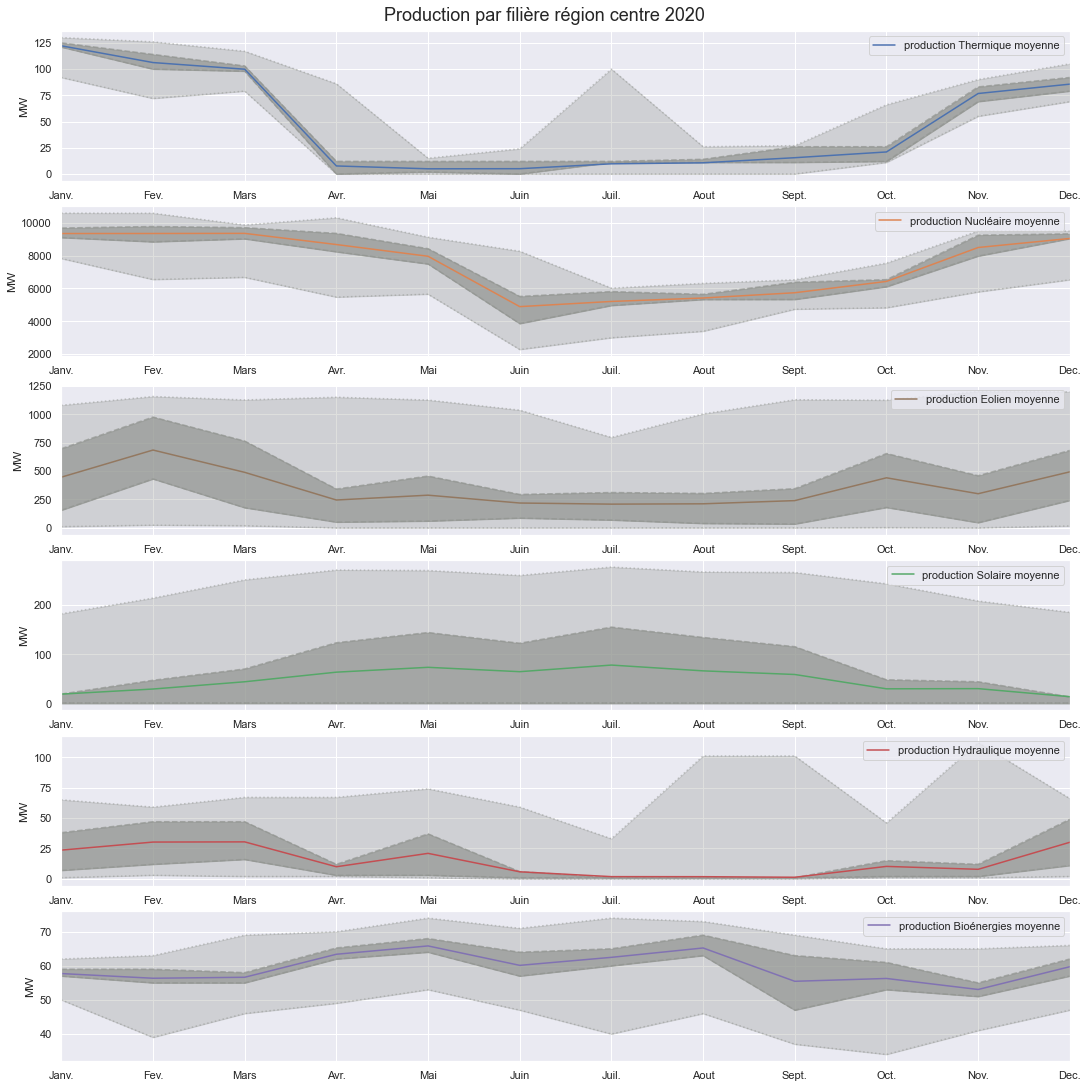

In [66]:
loopPlot(data=month, x_label=mois, title="Production par filière région centre 2020");

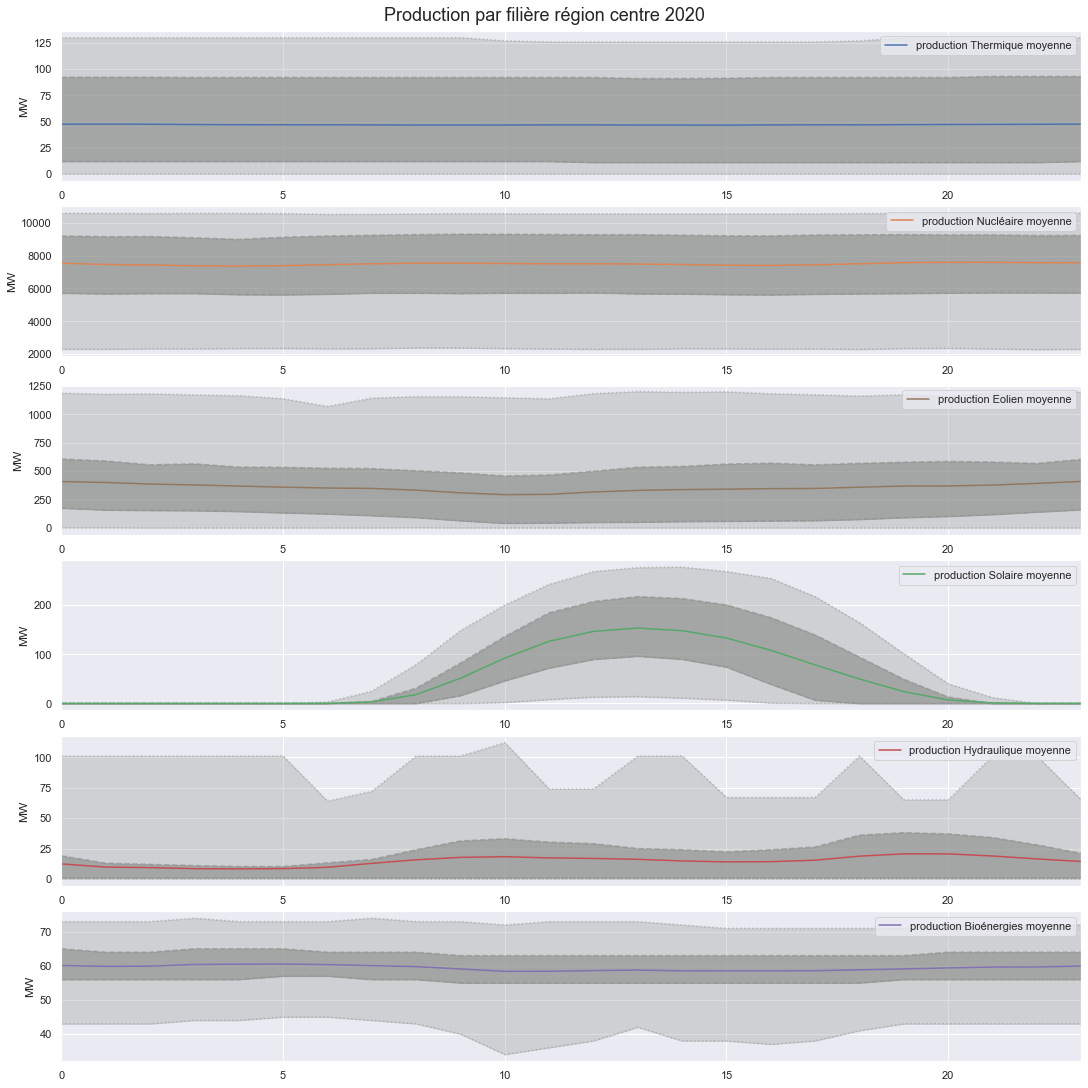

In [65]:
loopPlot(data=hour, title="Production par filière région centre 2020");